In [1]:
import os, ee, pickle
import warnings, math
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta

In [2]:
import geemap
import ipyleaflet

In [3]:
ee.Initialize()

In [4]:
shapefile = gpd.read_file("files/AllPossibleMeadows_2024-02-12.shp")

In [5]:
landsat8_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterDate('2018-10-01', '2019-10-01')
flow_acc = ee.Image("WWF/HydroSHEDS/15ACC").select('b1')
gridmet = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('2018-10-01', '2019-10-01').select(['tmmn', 'tmmx'])
dem = ee.Image('USGS/SRTMGL1_003').select('elevation')

In [6]:
def maskImage(image):
    quality = image.select('QA_PIXEL')
    cloud = quality.bitwiseAnd(1 << 3).eq(0)    # mask out cloudy pixels
    cloudShadow = quality.bitwiseAnd(1 << 4).eq(0)     # mask out cloud shadow
    snow = quality.bitwiseAnd(1 <<5).eq(0)     # mask out snow
    return image.updateMask(cloud).updateMask(cloudShadow).updateMask(snow)

In [7]:
meadowId = 17263
feature = shapefile.loc[meadowId, 'geometry']
tot_area = shapefile.loc[meadowId, 'Area_km2']
if feature.geom_type == 'Polygon':
    shapefile_bbox = ee.Geometry.Polygon(list(feature.exterior.coords)).buffer(-5)
elif feature.geom_type == 'MultiPolygon':
    shapefile_bbox = ee.Geometry.MultiPolygon(list(list(poly.exterior.coords) for poly in feature.geoms)).buffer(-5)

In [8]:
landsat_images = landsat8_collection.filterBounds(shapefile_bbox).map(maskImage)
image_list = landsat_images.toList(landsat_images.size())
landsat_image = ee.Image(image_list.get(0)).clip(shapefile_bbox)

In [9]:
band_values = landsat_image.reduceRegion(ee.Reducer.toList(), shapefile_bbox, 30).getInfo()
len(band_values['SR_B4'])

201923

In [10]:
def zoom_level(area=tot_area):
    ''' zoom_level ranges from 10 (largest of 369.83082 km2) to 19 (smallest of 0.0007 km2) for all polygons
     Each zoom-out approximately quadruples the area viewed (hence log 2)
     calculate deviation or zoom-out extent from 19 '''
    tradeoff = math.log2(area/0.0007)
    return (19 - round(tradeoff/2))

In [19]:
Map = geemap.Map(center=list(feature.centroid.coords[0])[::-1], zoom=zoom_level())
gdf_selected = gpd.GeoDataFrame(geometry=[feature])
geo_data = ipyleaflet.GeoData(geo_dataframe=gdf_selected, style={'color': 'red', 'fillOpacity':0.01})

Map.addLayer(landsat_image.clip(shapefile_bbox).mask(1), {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3}, 'Landsat Image', True, 0.5)
Map.add_layer(geo_data)

display(Map)

Map(center=[41.05916319742798, -121.41212721407936], controls=(WidgetControl(options=['position', 'transparent…

In [12]:
from osgeo import gdal
import numpy as np
import math
import matplotlib.pyplot as plt

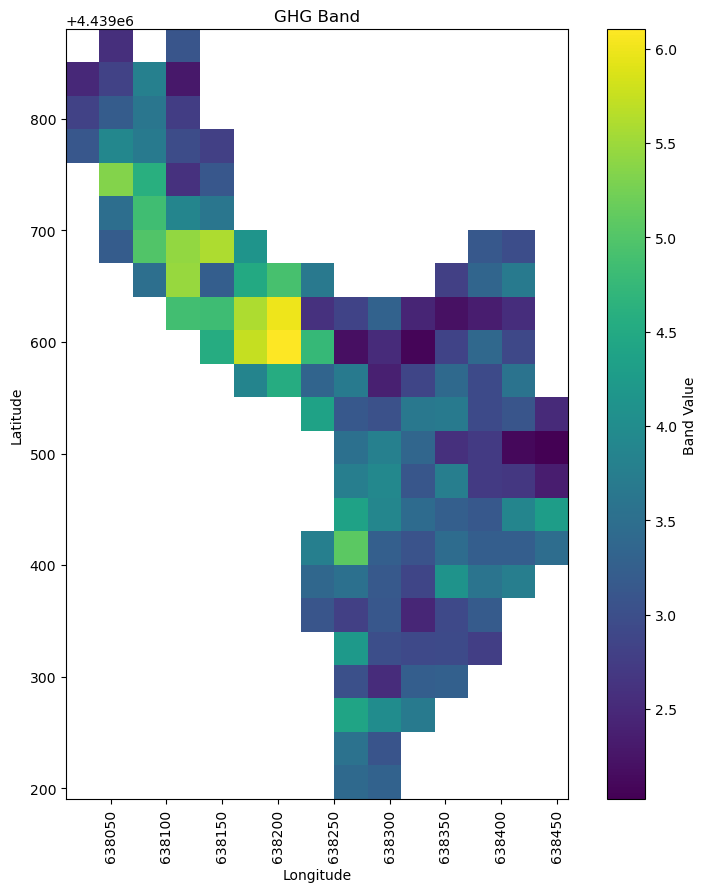

In [13]:
import rasterio
from rasterio.plot import show

with rasterio.open('files/Image_7_136433.tif') as src:
    # Band 1 & 2 are lon & lat; 19, 20 and 21 are GHG, AGB and BGB respectively
    band = src.read(19)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(band, extent=extent, cmap='viridis')
    plt.title('GHG Band')
    plt.colorbar(label='Band Value')
    plt.xlabel('Longitude', fontsize=10)
    plt.ylabel('Latitude', fontsize=10)
    plt.xticks(rotation='vertical', ha='center')
    plt.show()

In [13]:
coords = shapefile_bbox.bounds().coordinates().getInfo()[0]
xmin, ymin = coords[0]
xmax, ymax = coords[2]
num_subregions = round(math.sqrt(len(band_values['SR_B4'])/1250))

subregion_width = (xmax - xmin) / num_subregions
subregion_height = (ymax - ymin) / num_subregions
subregions = []

In [15]:
for i in range(num_subregions):
    for j in range(num_subregions):
        subregion = ee.Geometry.Rectangle([xmin + i*subregion_width, ymin + j*subregion_height,
                                           xmin + (i+1)*subregion_width, ymin + (j+1)*subregion_height])
        subregions.append(subregion)

In [20]:
Map = geemap.Map(center=list(feature.centroid.coords[0])[::-1], zoom=zoom_level())
gdf_selected = gpd.GeoDataFrame(geometry=[feature])
geo_data = ipyleaflet.GeoData(geo_dataframe=gdf_selected, style={'color': 'red', 'fillOpacity':0.01})

Map.addLayer(landsat_image.clip(subregions[1]).mask(1), {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3}, 'Landsat Image', True, 0.5)
Map.add_layer(geo_data)

display(Map)

Map(center=[41.05916319742798, -121.41212721407936], controls=(WidgetControl(options=['position', 'transparent…

In [21]:
len(subregions)

169